<a href="https://colab.research.google.com/github/dfu2020/ATMS-597-SP-2020-Project-3-Group-H/blob/master/Project_3_gpcp_download.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pylab inline
import xarray as xr

Populating the interactive namespace from numpy and matplotlib


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd /content/drive/My Drive/Project_3_gpcp/

/content/drive/My Drive/Project_3_gpcp


In [5]:
!pip install netcdf4
!pip install pydap
!pip install wget

     |████████████████████████████████| 4.1MB 49.7MB/s 
     |████████████████████████████████| 317kB 56.1MB/s 
     |████████████████████████████████| 2.3MB 17.1MB/s 
     |████████████████████████████████| 122kB 59.6MB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=c6f0a545bcad0b17b3f42e96d10eaaf275572ee9a89e9f1c0698049becf9b128
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
from datetime import datetime
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import re
import wget

In [7]:
years = np.arange(1996,2020)
url_home = 'https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/'
# Get the file names from the website by looping through each year
gpcp_file_name = []
datasets = []
for year in years:
    gpcp_url=url_home +str(year)+'/'
    response = requests.get(gpcp_url)

    soup = BeautifulSoup(response.text, 'html.parser')
    gpcp_file_list = soup.find_all('a', href=re.compile("\.nc$"))
    #print(len(gpcp_file_list))
    print(year)
    for s in gpcp_file_list:
        filename=s.contents[0]
        file_url = (gpcp_url+filename)
        #print(file_url)
        wget.download(file_url)
        nc = xr.open_dataset(filename)
        precip = xr.DataArray(nc['precip'],dims=['time','latitude','longitude']) # load the precip data into a data array 
        datasets.append(precip) #append the datasets list with the precip data array
        !rm "{filename}"
combined = xr.concat(datasets, dim='time')

1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [0]:
combined_dataset = combined.to_dataset(name='precip')

In [0]:
mdata=combined_dataset.sel(time=~combined_dataset.indexes['time'].duplicated())
mdata_season=mdata.sel(time=(mdata['time.season'] == 'DJF'))

In [0]:
mdata.to_netcdf('combined_1996_2019_precip.nc')

In [0]:
#md = xr.open_dataset('combined_1996_2019_precip.nc')

In [0]:
mdata_melbourne = mdata_season.sel(longitude=slice(144.9631-1,144.9631+1),latitude=slice(-37.8136-1,-37.8136+1))
#melbourne_new = np.where(mdata_melbourne>=0)
#melbourne_precip=mdata_season.sel(longitude=145.,latitude=-38., method='nearest')

In [0]:
cond=np.where((mdata_melbourne.precip.values>=0.)&(mdata_melbourne.precip.values<=100.))

In [54]:
melbourne_results=mdata_melbourne.precip.values[cond]
np.percentile(melbourne_results,95)

9.186779069900508

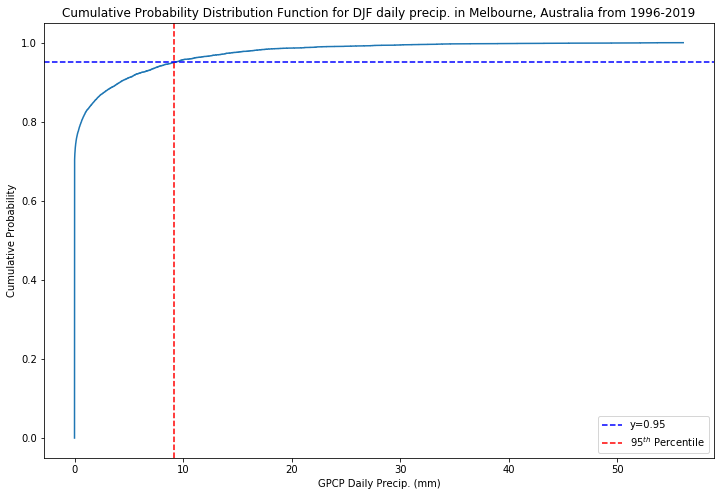

In [47]:
n = np.arange(1,len(melbourne_results)+1) / np.float(len(melbourne_results))
Xs = np.sort(melbourne_results)
fig, ax = plt.subplots(figsize=(12,8))
ax.step(Xs,n) 
plt.axhline(0.95,c='b',ls='--',label='y=0.95')
plt.axvline(np.percentile(melbourne_results,95),c='r',ls='--',label='$95^{th}$ Percentile')
plt.xlabel('GPCP Daily Precip. (mm)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability Distribution Function for DJF daily precip. in Melbourne, Australia from 1996-2019')
plt.legend()
plt.show()

In [0]:
melbourne_95 = mdata_melbourne.where(mdata_melbourne.precip >= np.percentile(melbourne_results,95),drop=True)

In [0]:
melbourne_95.to_netcdf('melbourne_95.nc',encoding={'precip': {'_FillValue': -9999.0}})